In [1]:
import mido
from matplotlib import pyplot as plt
import numpy as np
import os
from math import sqrt

np.set_printoptions(suppress=True)

In [2]:
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/lib/cuda'
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import sys  

sys.path.insert(0, '/raid/shumnov/music-style-performer/src/discriminator')

In [4]:
PROJECT_PATH = '/raid/shumnov/music-style-performer/'

# Discriminator

In [5]:
from model import *
from data_preprocessing import *

In [6]:
architecture = [((64, 32), (0, 0), (32, 64), (0, 0)), 
                ((64, 32, 32), (0, 0, 0), (32, 32, 64), (0, 0, 0))]
weights = [(1, 1), (2, 5)]
latent_dim = [16, 32]
absolute_velocities = [True, False]

In [7]:
config = (0, 0, 1, 0)

arch = architecture[config[0]]
w = weights[config[1]]
ld = latent_dim[config[2]]
av = absolute_velocities[config[3]]

In [8]:
dp = DataProcessor(
    notes_qty=16, 
    include_first_tone=False, 
    absolute_velocities=av)

dset = Dataset(dp, 32)
dset.load_dset(PROJECT_PATH + 'data/dset20.npy', PROJECT_PATH + 'data/test_dset20.npy')
#dp.saveparams('normparams.txt')
#dp.loadparams('normparams.txt')

In [9]:
autoencoder = MLPAutoencoder(
    input_size=dp.input_size,
    latent_dim=ld,
    noise=0.02,
    encoder_layers=arch[0],
    encoder_dropout=arch[1],
    decoder_layers=arch[2],
    decoder_dropout=arch[3])

In [66]:
model = OCCModel(autoencoder, dp, 0, 1, 2.5)

model.load(PROJECT_PATH+f'traindata/' + ''.join(map(str, config)) + '/checkpoints/ckpt-7')

# Data

In [67]:
def Note(tone, time, duration, velocity, dist):
    return [tone, time, duration, velocity, dist]

In [68]:
def track2line(track, ticks_per_beat):
    line = []

    time = 0
    for m in track:
        time += m.time / ticks_per_beat / 2

        if m.type == 'note_on' and m.velocity > 0:
            if len(line) > 0:
                line[-1][4] = time - line[-1][1]
            line.append(Note(m.note, time, -1, m.velocity, -1))
            
        elif m.type == 'note_off' or (m.type == 'note_on' and m.velocity == 0):
            i = 1
            while line[-i][0] != m.note:
                i += 1
            
            line[-i][2] = time - line[-i][1]
    
    if len(line) > 0:
        line[-1][4] = line[-1][2]
            
    return line

In [69]:
def graph_line(line, yi=0):
    x = np.cumsum(line[..., 1])
    y = line[..., yi]
    
    plt.plot(x, y, 'o-')
    plt.show()

In [70]:
mid1 = mido.MidiFile('satie_clean.mid')
mid2 = mido.MidiFile('prokofiev.mid')

In [71]:
line = track2line(mid1.tracks[0], mid1.ticks_per_beat)
line = np.array(line)

line[..., 1] = line[..., 4]
vels = line[..., 3].copy()
line[..., 3] = line[..., 2] / line[..., 1]
line[..., 2] = vels
line = np.delete(line, 4, -1)

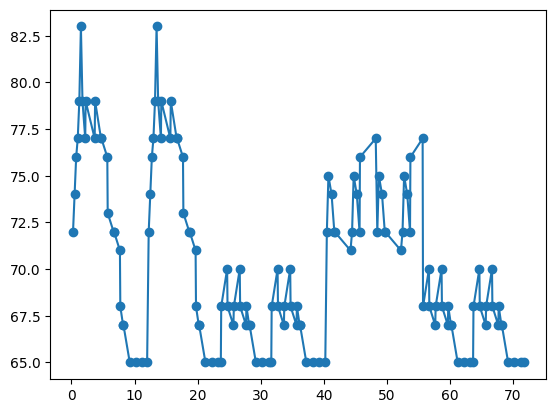

In [72]:
graph_line(line)

In [73]:
base = np.squeeze(sliding_window_view(line, (dp.notes_qty, 4))).copy()
dist = tf.convert_to_tensor(base[..., 1], dtype=tf.float32)

base, fbase = dp.make_relative(base)
base, fbase = dp.normalize(base, fbase, False)

fbase = np.concatenate([np.zeros((fbase.shape[0], 1)), fbase], axis=1)
fbase = np.expand_dims(fbase, axis=1)
base = np.concatenate([fbase, base], axis=1)

note = tf.convert_to_tensor(base[..., 0], dtype=tf.float32)
note = np.expand_dims(note, axis=2)

In [74]:
dtstart = np.random.normal(0, 0, (len(line)))
velstart = np.random.normal(70, 20, (len(line)))
legstart = np.random.normal(1, 0.3, (len(line)))

dt = tf.Variable(dtstart, dtype=tf.float32) # constraint=lambda t: tf.clip_by_value(t, DTMIN, DTMAX))
vel = tf.Variable(velstart, dtype=tf.float32)
leg = tf.Variable(legstart, dtype=tf.float32)

In [75]:
DT_MAX = 0.1

def dt_norm(dt):
    return DT_MAX * (2 / (1 + tf.math.exp(-dt)) - 1)

def dt_additive(dt):
    dt = tf.concat([dt_norm(dt), tf.constant(0, shape=(1,), dtype=tf.float32)], axis=0)
    return tf.experimental.numpy.diff(dt)

In [76]:
@tf.function
def process(dt, vel, leg):
    dt = dt_additive(dt)
    
    # window
    dt_windows = []
    vel_windows = [] 
    leg_windows = []
    for i in range(len(note)):
        dt_windows.append(dt[i: i + dp.notes_qty])
        vel_windows.append(vel[i: i + dp.notes_qty])
        leg_windows.append(leg[i: i + dp.notes_qty])
    pdt = tf.stack(dt_windows, axis=0)
    pvel = tf.stack(vel_windows, axis=0)
    pleg = tf.stack(leg_windows, axis=0)

    # relative velocities
    fpvel = pvel[..., 0]
    if dp.absolute_velocities:
        pvel = pvel[:, 1:]
    else:
        pvel = tf.experimental.numpy.diff(pvel)
        
    # apply dt
    pdt = dist + pdt

    # normalize
    fpvel = (fpvel - dp.normparams[5]) / dp.normparams[6]
    pvel = (pvel - dp.normparams[3]) / dp.normparams[4]
    pleg = pleg - 1
    pdt = pdt / dp.normparams[2]
    
    # reshape
    pvel = tf.concat([tf.expand_dims(fpvel, axis=1), pvel], axis=1)
    res = tf.stack([pdt, pvel, pleg], axis=2)
    res = tf.concat([note, res], axis=2)
    
    return tf.reshape(res, (res.shape[0], res.shape[1] * res.shape[2]))[:, 1:]

In [77]:
model.predict(process(dt, vel, leg))

<tf.Tensor: shape=(119,), dtype=float32, numpy=
array([0.0748362 , 0.06880009, 0.07764329, 0.07092519, 0.06592356,
       0.05707372, 0.05944667, 0.05658833, 0.05478256, 0.06908309,
       0.08447931, 0.0716961 , 0.04354458, 0.05507715, 0.066357  ,
       0.07603353, 0.07776839, 0.07192875, 0.06575305, 0.0635092 ,
       0.08158211, 0.13934283, 0.1512275 , 0.12558313, 0.13199428,
       0.1307856 , 0.14418875, 0.13155816, 0.13514645, 0.11422665,
       0.09453678, 0.07644757, 0.08415712, 0.08323377, 0.0835738 ,
       0.09557688, 0.11314066, 0.17892042, 0.1561564 , 0.07084517,
       0.07622893, 0.1024996 , 0.10221211, 0.09048676, 0.08834101,
       0.08973062, 0.10319842, 0.11969175, 0.13789988, 0.15163548,
       0.18608901, 0.2437617 , 0.23260066, 0.21414283, 0.22547364,
       0.22931221, 0.2248566 , 0.22617865, 0.24229492, 0.28801903,
       0.26870707, 0.2871716 , 0.28285027, 0.22252314, 0.17107725,
       0.12781152, 0.12465773, 0.1253257 , 0.11201739, 0.10790811,
       0.10458

In [78]:
A = 0
B = 0
C = 1

In [79]:
@tf.function()
def style_loss(dt, vel, leg): 
    return tf.constant(0, dtype=tf.float32)

@tf.function()
def content_loss(dt, vel, leg):
    return tf.constant(0, dtype=tf.float32)
    # return tf.math.reduce_mean(tf.math.square(pred - content))

@tf.function()
def quality_loss(dt, vel, leg):
    data = process(dt, vel, leg)
    loss = model.predict(data)  
    loss = tf.reduce_mean(loss) 
    
    return loss

@tf.function()
def overall_loss(dt, vel, leg):
    # return A * style_loss(vel, leg) + B * content_loss(vel, leg) + 
    return C * quality_loss(dt, vel, leg)

In [80]:
opt = tf.keras.optimizers.Adam(learning_rate=0.01)

In [81]:
@tf.function()
def train_step(dt, vel, leg):    
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(vel)
        tape.watch(leg)
        # tape.watch(dt)
        loss = overall_loss(dt, vel, leg)

    # gdt = tape.gradient(loss, dt)
    gvel = tape.gradient(loss, vel)
    gleg = tape.gradient(loss, leg)
    
    opt.apply_gradients([(gvel, vel), (gleg, leg)]) #(gdt, dt)])
    
    return loss

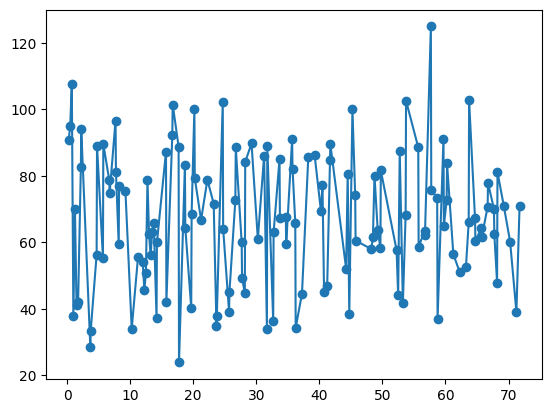

In [82]:
x = np.cumsum(line[..., 1])
y = vel

plt.plot(x, y, 'o-')
plt.show()

In [100]:
import time
start = time.time()

epochs = 30
steps_per_epoch = 500

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        loss = train_step(dt, vel, leg)
    print(f"Step: {step} | style_loss: {style_loss(dt, vel, leg)} | quality_loss: {quality_loss(dt, vel, leg)}")

end = time.time()
print("Total time: {:.1f}".format(end-start))

Step: 500 | style_loss: 0.0 | quality_loss: 0.0003062871692236513
Step: 1000 | style_loss: 0.0 | quality_loss: 0.0003049047663807869
Step: 1500 | style_loss: 0.0 | quality_loss: 0.000303866429021582
Step: 2000 | style_loss: 0.0 | quality_loss: 0.0003029284125659615
Step: 2500 | style_loss: 0.0 | quality_loss: 0.0003023784374818206
Step: 3000 | style_loss: 0.0 | quality_loss: 0.0003019059950020164
Step: 3500 | style_loss: 0.0 | quality_loss: 0.0003015114343725145
Step: 4000 | style_loss: 0.0 | quality_loss: 0.00030128462822176516
Step: 4500 | style_loss: 0.0 | quality_loss: 0.0003011355292983353
Step: 5000 | style_loss: 0.0 | quality_loss: 0.00030101422453299165
Step: 5500 | style_loss: 0.0 | quality_loss: 0.000300916115520522
Step: 6000 | style_loss: 0.0 | quality_loss: 0.00030082257580943406
Step: 6500 | style_loss: 0.0 | quality_loss: 0.00030077164410613477
Step: 7000 | style_loss: 0.0 | quality_loss: 0.00030070479260757565
Step: 7500 | style_loss: 0.0 | quality_loss: 0.0003006871265

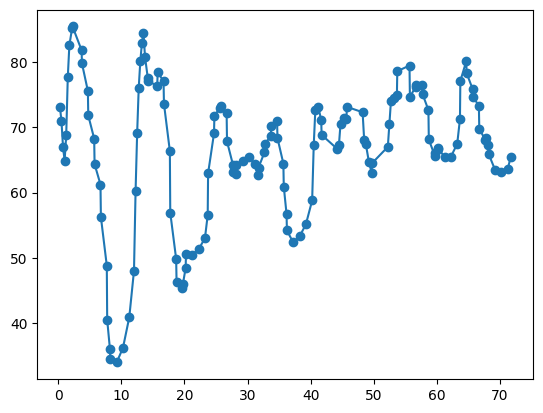

In [99]:
x = np.cumsum(line[..., 1])
y = vel # dt_norm(dt)

plt.plot(x, y, 'o-')
plt.show()

In [86]:
tf.reduce_mean(model.predict(process(dt, vel, leg)))

<tf.Tensor: shape=(), dtype=float32, numpy=0.00030814356>

In [98]:
tf.reduce_mean(model.predict(process(dt, vel, tf.random.normal((len(line),), mean=1, stddev=0.0, ))))

<tf.Tensor: shape=(), dtype=float32, numpy=0.00091541064>

In [65]:
events = []
time = 0

line[..., 1] += dt_additive(dt)

for i in range(len(line)):
    diff = int(line[i][1] * mid1.ticks_per_beat * 2)
    
    events.append([time, int(line[i][0]), int(vel[i]), 'note_on'])
    events.append([time + int(diff * leg[i]), int(line[i][0]), 0, 'note_off'])
    time += diff
    
events.sort(key=lambda e: e[0])
    
mid = mido.MidiFile(type=0)
mid.ticks_per_beat = mid1.ticks_per_beat
track = mido.MidiTrack()
mid.tracks.append(track)

track.append(mido.Message(events[0][3], note=events[0][1], velocity=events[0][2], time=events[0][0]))
prev = 0

for e in events[1:]:
    diff = e[0] - prev
    prev = e[0]
    track.append(mido.Message(e[3], note=e[1], velocity=e[2], time=diff))
    
mid.save('satie_3.mid')

In [62]:
print(line[..., 1])

[ 0.38218379  0.3388859   0.40359569  0.19915117  0.53428924  0.34478354
  0.19397461  0.73376346  0.08579328  2.02153277  0.34500903  1.26111329
 -0.02574524  1.35029268  0.27653956  1.12344599  0.27462432  1.15521705
  0.32148722  0.43288949  0.16832624  1.54489565  1.53505945  1.31816363
  1.20150363  0.59908432  0.32117245  0.14747681  0.31063122  0.54494888
  0.34322798  0.35049763  0.76589304 -0.08372144  2.11597967  0.30895567
  1.26852894  0.11683677  1.43416846  0.16371961  1.28119981  0.16869083
  1.26175058  0.33001819  0.53513801  0.3379299   1.45233428  1.53526354
  1.55383182  0.90024501  0.38026926  1.16173542  0.24128252  1.20011759
  0.33043468  1.14282417  0.35076827  1.16730332  0.33668476  0.60303211
  0.15317197  1.42264724  1.22775722  1.61224902  0.67419708  0.42536625
  1.18611169  0.1289894   1.35992849  0.31565005  1.16615021  0.33509487
  1.33979499  0.19634414  0.68305945  0.2479721   1.4641273   1.4697417
  1.56928444  1.07919407]


In [29]:
# i = 0

# for m in mid2.tracks[0]:
#     if m.type == 'note_on' and m.velocity > 0:
#         m.velocity = int(vel[i])
        
#         i += 1
        
# mid2.save('result1.mid')